# Redirection Networks - Random Iteration

### Marcos Costa Santos Carreira

## Imports

In [1]:
import networkx as nx
import random as rd
from fractions import Fraction
# from math import factorial, log10
# from collections import Counter
# from collections.abc import Iterable
# from itertools import permutations
from more_itertools import locate
# import functools

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
from tqdm.notebook import tqdm

In [4]:
# from mpl_toolkits.mplot3d import Axes3D

## Functions

#### Definitions - Initialization

In [5]:
def build_tree(edges):
    g = nx.Graph()
    g.update(edges)
    return g

In [6]:
init = build_tree([(0, 1)])
[init.edges, init.nodes, init.order(), init.size(), init.degree]

[EdgeView([(0, 1)]), NodeView((0, 1)), 2, 1, DegreeView({0: 1, 1: 1})]

In [7]:
def hashk(g):
    return nx.weisfeiler_lehman_graph_hash(g)

#### Data structures for the possible networks

In [52]:
class Network(object):
    def __init__(self, g):
        self._graph = g
        self._hash = hashk(self._graph)
        self._prob = 0
        self.calc_basic()
        
    def calc_basic(self):
        self._n = self._graph.order()
        self._degrees = self._graph.degree
        self._deg_values = dict(self._degrees).values()
        self._max_degree = max(self._deg_values) # d
        self._max_degree_f = Fraction(self._max_degree, self._n) # x
        self._max_degree_i = list(locate(self._deg_values, lambda x: x == self._max_degree))
        self._max_degree_n = len(self._max_degree_i) # m
        self._nodes = list(self._graph.nodes)
        self._leaves = [k for k in self._nodes if self._degrees[k] == 1]
        self._hubs = list(set(self._nodes) - set(self._leaves))
        self._l = len(self._leaves)
        self._h = self._n - self._l
        self._hf = Fraction(self._h, self._n) # y
        self._coord = (self._max_degree_f, self._hf)
        
    def calc_cores_branches(self):
        gc = nx.Graph()
        gc.add_nodes_from(self._graph)
        gc.add_edges_from(self._graph.edges)
        gc.remove_nodes_from(self._leaves)
        gc_degrees = gc.degree
        self._h_degrees = {k: self._degrees[k] for k in self._hubs}
        self._h_nr_leaves = {k: self._degrees[k] - gc_degrees[k] for k in self._hubs}
        self._cores = [k for k in self._hubs if self._h_nr_leaves[k] == 0]
        self._branches = list(set(self._hubs) - set(self._cores))
        self._b = len(self._branches)
        self._c = len(self._cores)
    
    def calc_dph(self, ph):
        if self._h == 0:
            return 1
        else:
            return Fraction(self._n * ph - self._h, self._n * (self._n + 1))

    def calc_mu(self, ph):
        if self._h == 0:
            return 1
        else:
            return Fraction(self._n * ph - self._h, self._h * (self._n + 1))
    
    def calc_mus(self, model='CR'):
        if self._h == 0:
            self._ph = 1
        else:
            if model == 'NR':
                self._ph = Fraction(self._l, self._n)
            elif model == 'XR':
                self._ph = Fraction(self._h, self._n)
            elif model == 'HR':
                self._ph = Fraction(self._l * self._h, self._n * (self._n - 1))
            elif model == 'FR':
                self._ph = Fraction(self._l * self._b, self._n * (self._n - 1))
            else:                 
                self._ph = Fraction(1, self._n) * \
                    sum([Fraction(self._h_nr_leaves[k], self._h_degrees[k]) for k in self._hubs])                   
        self._dph = self.calc_dph(self._ph)
        self._mu = self.calc_mu(self._ph)

    def calc_dpd(self, pd):
        if self._h == 0:
            return 1
        else:
            return Fraction(self._n * pd - self._max_degree, self._n * (self._n + 1))

    def calc_ro(self, pd):
        if self._h == 0:
            return 1
        else:
            return Fraction(self._n * pd - self._max_degree, self._max_degree * (self._n + 1))

    def calc_ros(self, model='CR'):
        self._ch_md = {k: (1 * (k in self._branches)) for k in self._max_degree_i}
        if self._h == 0:
            self._pd = 1
        else:
            if model == 'NR':
                self._pd = Fraction(self._max_degree_n, self._n)
            elif model == 'XR':
                self._pd = Fraction(self._l * self._max_degree_n, self._n * self._h)
            elif model == 'HR':
                self._pd = Fraction(self._max_degree_n, self._n) *\
                    (Fraction(self._l, self._h) +
                     Fraction(self._h - 1, self._n - 1))
            elif model == 'FR':
                self._pd = Fraction(
                    sum([(
                        self._ch_md[k] * Fraction(self._l, self._b) +
                        Fraction(self._b - self._ch_md[k], self._n - 1) +
                        Fraction(self._c + self._ch_md[k] - 1, max(1, self._h - 1)))
                        for k in self._max_degree_i]),
                    self._n)
            else:                 
                self._pd = Fraction(
                    sum([
                        sum([Fraction(1, self._degrees[j]) for j in self._graph.neighbors(k)])
                        for k in self._max_degree_i]),
                    self._n)                
        self._dpd = self.calc_dpd(self._pd)
        self._ro = self.calc_ro(self._pd)
        
    def clear_prob(self, p):
        self._prob = 0        
        
    def update_prob(self, p):
        self._prob = self._prob + p

In [53]:
initN = Network(init)
initN.update_prob(1)
initN.calc_cores_branches()
initN.calc_mus()
initN.calc_ros()

#### Definitions - Random Iterations

In [10]:
def series_to_colors(s, cmap='coolwarm'):
    color_map = plt.get_cmap(cmap)
    return s.apply(color_map)

##### No redirection

In [11]:
def next_rnd_nr(g):
    gc = nx.Graph()
    gc.add_nodes_from(g)
    gc.add_edges_from(g.edges)
    nodes = list(g.nodes)
    attach = rd.choice(nodes)
    gc.add_edge(attach, g.order())
    return gc

In [12]:
def loop_rnd_nr(g, n):
    gc = nx.Graph()
    gc.add_nodes_from(g)
    gc.add_edges_from(g.edges)
    for k in tqdm(range(n)):
        gc = next_rnd_nr(gc)
    return gc

In [13]:
def tracked_loop_rnd_nr(g, n):
    gc = nx.Graph()
    gc.add_nodes_from(g)
    gc.add_edges_from(g.edges)
    coord_list = []
    rel_size_list = []
    for k in tqdm(range(n)):
        gc = next_rnd_nr(gc)
        gcn = Network(gc)
        coord_list.append(gcn._coord)
        rel_size_list.append(Fraction(gcn._n, g.order() + n))
    df_coord = pd.DataFrame(coord_list, columns = ['MaxD', 'Nucl'])
    df_coord['Rel_Size'] = rel_size_list
    return [gc, df_coord]

In [52]:
%%time

test1 = loop_rnd_nr(init, 500)

  0%|          | 0/500 [00:00<?, ?it/s]

CPU times: user 222 ms, sys: 4.55 ms, total: 226 ms
Wall time: 223 ms


In [53]:
%%time

test1, df_test1 = tracked_loop_rnd_nr(init, 500)

  0%|          | 0/500 [00:00<?, ?it/s]

CPU times: user 660 ms, sys: 6.92 ms, total: 667 ms
Wall time: 663 ms


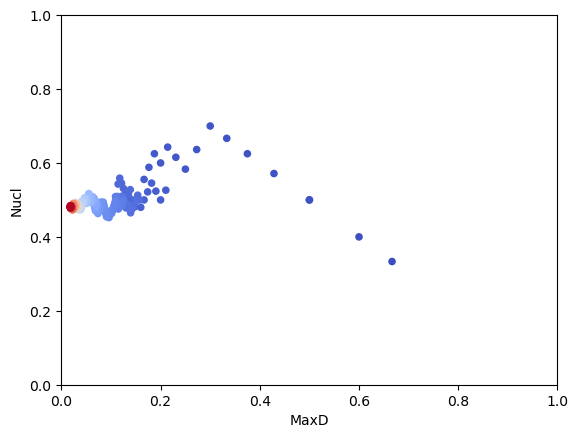

In [54]:
df_test1.plot.scatter(x='MaxD', y='Nucl', c=series_to_colors(df_test1['Rel_Size']*1.),
                     xlim=(0, 1), ylim=(0, 1));

##### Cross redirection

In [14]:
def next_rnd_xr(g):
    gn = Network(g)
    gc = nx.Graph()
    gc.add_nodes_from(g)
    gc.add_edges_from(g.edges)
    nodes = list(gn._nodes)
    n = rd.choice(nodes)
    gn.calc_cores_branches()
    leaves = gn._leaves
    hubs = gn._hubs
    if n in leaves:
        if g.order() == 2:
            neighbors = [1 - n]
        else:
            neighbors = hubs.copy()
    else:
        neighbors = leaves.copy()
    attach = rd.choice(neighbors)
    gc.add_edge(attach, g.order())
    return gc

In [15]:
def loop_rnd_xr(g, n):
    gc = nx.Graph()
    gc.add_nodes_from(g)
    gc.add_edges_from(g.edges)
    for k in tqdm(range(n)):
        gc = next_rnd_xr(gc)
    return gc

In [16]:
def tracked_loop_rnd_xr(g, n):
    gc = nx.Graph()
    gc.add_nodes_from(g)
    gc.add_edges_from(g.edges)
    coord_list = []
    rel_size_list = []
    for k in tqdm(range(n)):
        gc = next_rnd_xr(gc)
        gcn = Network(gc)
        coord_list.append(gcn._coord)
        rel_size_list.append(Fraction(gcn._n, g.order() + n))
    df_coord = pd.DataFrame(coord_list, columns = ['MaxD', 'Nucl'])
    df_coord['Rel_Size'] = rel_size_list
    return [gc, df_coord]

In [63]:
%%time

test5 = loop_rnd_xr(init, 5000)

  0%|          | 0/5000 [00:00<?, ?it/s]

CPU times: user 1min 21s, sys: 689 ms, total: 1min 22s
Wall time: 1min 22s


In [64]:
%%time

test5, df_test5 = tracked_loop_rnd_xr(init, 5000)

  0%|          | 0/5000 [00:00<?, ?it/s]

CPU times: user 2min 6s, sys: 1.04 s, total: 2min 7s
Wall time: 2min 6s


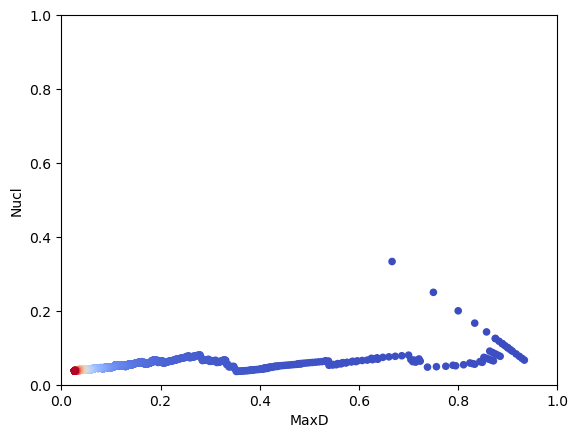

In [65]:
df_test5.plot.scatter(x='MaxD', y='Nucl', c=series_to_colors(df_test5['Rel_Size']*1.),
                     xlim=(0, 1), ylim=(0, 1));

##### Hub redirection

In [17]:
def next_rnd_hr(g):
    gn = Network(g)
    gc = nx.Graph()
    gc.add_nodes_from(g)
    gc.add_edges_from(g.edges)
    nodes = list(gn._nodes)
    n = rd.choice(nodes)
    gn.calc_cores_branches()
    leaves = gn._leaves
    branches = gn._branches
    if n in leaves:
        if g.order() == 2:
            neighbors = [1 - n]
        else:
            neighbors = branches.copy()
    else:
        nodes_ex = nodes.copy()
        nodes_ex.remove(n)
        neighbors = nodes_ex.copy()
    attach = rd.choice(neighbors)
    gc.add_edge(attach, g.order())
    return gc

In [18]:
def loop_rnd_hr(g, n):
    gc = nx.Graph()
    gc.add_nodes_from(g)
    gc.add_edges_from(g.edges)
    for k in tqdm(range(n)):
        gc = next_rnd_hr(gc)
    return gc

In [19]:
def tracked_loop_rnd_hr(g, n):
    gc = nx.Graph()
    gc.add_nodes_from(g)
    gc.add_edges_from(g.edges)
    coord_list = []
    rel_size_list = []
    for k in tqdm(range(n)):
        gc = next_rnd_hr(gc)
        gcn = Network(gc)
        coord_list.append(gcn._coord)
        rel_size_list.append(Fraction(gcn._n, g.order() + n))
    df_coord = pd.DataFrame(coord_list, columns = ['MaxD', 'Nucl'])
    df_coord['Rel_Size'] = rel_size_list
    return [gc, df_coord]

In [60]:
%%time

test4 = loop_rnd_hr(init, 5000)

  0%|          | 0/5000 [00:00<?, ?it/s]

CPU times: user 1min 27s, sys: 611 ms, total: 1min 27s
Wall time: 1min 27s


In [61]:
%%time

test4, df_test4 = tracked_loop_rnd_hr(init, 5000)

  0%|          | 0/5000 [00:00<?, ?it/s]

CPU times: user 2min 9s, sys: 989 ms, total: 2min 10s
Wall time: 2min 10s


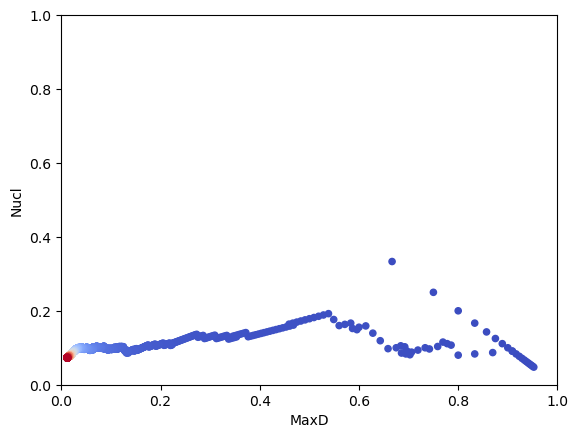

In [62]:
df_test4.plot.scatter(x='MaxD', y='Nucl', c=series_to_colors(df_test4['Rel_Size']*1.),
                     xlim=(0, 1), ylim=(0, 1));

##### Fuzzy redirection

In [20]:
def next_rnd_fr(g):
    gn = Network(g)
    gc = nx.Graph()
    gc.add_nodes_from(g)
    gc.add_edges_from(g.edges)
    nodes = list(gn._nodes)
    n = rd.choice(nodes)
    gn.calc_cores_branches()
    leaves = gn._leaves
    branches = gn._branches
    cores = gn._cores
    if n in leaves:
        if g.order() == 2:
            neighbors = [1 - n]
        else:
            neighbors = branches.copy()
    elif n in cores:
        cores_ex = cores.copy()
        cores_ex.remove(n)
        neighbors = branches + cores_ex
    else:
        nodes_ex = nodes.copy()
        nodes_ex.remove(n)
        neighbors = nodes_ex.copy()
    attach = rd.choice(neighbors)
    gc.add_edge(attach, g.order())
    return gc

In [21]:
def loop_rnd_fr(g, n):
    gc = nx.Graph()
    gc.add_nodes_from(g)
    gc.add_edges_from(g.edges)
    for k in tqdm(range(n)):
        gc = next_rnd_fr(gc)
    return gc

In [22]:
def tracked_loop_rnd_fr(g, n):
    gc = nx.Graph()
    gc.add_nodes_from(g)
    gc.add_edges_from(g.edges)
    coord_list = []
    rel_size_list = []
    for k in tqdm(range(n)):
        gc = next_rnd_fr(gc)
        gcn = Network(gc)
        coord_list.append(gcn._coord)
        rel_size_list.append(Fraction(gcn._n, g.order() + n))
    df_coord = pd.DataFrame(coord_list, columns = ['MaxD', 'Nucl'])
    df_coord['Rel_Size'] = rel_size_list
    return [gc, df_coord]

In [58]:
%%time

test3 = loop_rnd_fr(init, 5000)

  0%|          | 0/5000 [00:00<?, ?it/s]

CPU times: user 1min 19s, sys: 528 ms, total: 1min 19s
Wall time: 1min 19s


In [29]:
%%time

test3, df_test3 = tracked_loop_rnd_fr(init, 5000)

  0%|          | 0/5000 [00:00<?, ?it/s]

CPU times: user 2min 7s, sys: 1.02 s, total: 2min 8s
Wall time: 2min 8s


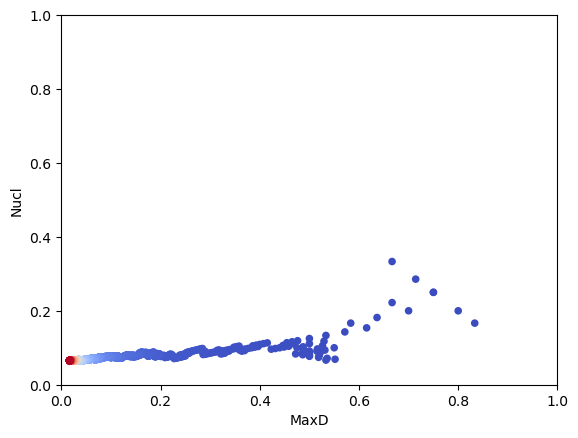

In [59]:
df_test3.plot.scatter(x='MaxD', y='Nucl', c=series_to_colors(df_test3['Rel_Size']*1.),
                     xlim=(0, 1), ylim=(0, 1));

##### Complete redirection

In [23]:
def next_rnd_cr(g):
    gc = nx.Graph()
    gc.add_nodes_from(g)
    gc.add_edges_from(g.edges)
    nodes = list(g.nodes)
    n = rd.choice(nodes)
    neighbors = list(g.neighbors(n))
    attach = rd.choice(neighbors)
    gc.add_edge(attach, g.order())
    return gc

In [24]:
def loop_rnd_cr(g, n):
    gc = nx.Graph()
    gc.add_nodes_from(g)
    gc.add_edges_from(g.edges)
    for k in tqdm(range(n)):
        gc = next_rnd_cr(gc)
    return gc

In [25]:
def tracked_loop_rnd_cr(g, n):
    gc = nx.Graph()
    gc.add_nodes_from(g)
    gc.add_edges_from(g.edges)
    coord_list = []
    rel_size_list = []
    for k in tqdm(range(n)):
        gc = next_rnd_cr(gc)
        gcn = Network(gc)
        coord_list.append(gcn._coord)
        rel_size_list.append(Fraction(gcn._n, g.order() + n))
    df_coord = pd.DataFrame(coord_list, columns = ['MaxD', 'Nucl'])
    df_coord['Rel_Size'] = rel_size_list
    return [gc, df_coord]

In [26]:
%%time

test2 = loop_rnd_cr(init, 5000)

  0%|          | 0/5000 [00:00<?, ?it/s]

CPU times: user 20.8 s, sys: 265 ms, total: 21.1 s
Wall time: 21 s


In [56]:
%%time

test2, df_test2 = tracked_loop_rnd_cr(init, 5000)

  0%|          | 0/5000 [00:00<?, ?it/s]

CPU times: user 1min 2s, sys: 409 ms, total: 1min 3s
Wall time: 1min 3s


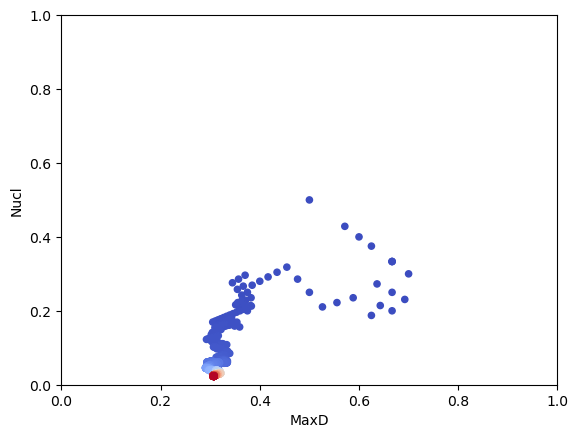

In [57]:
df_test2.plot.scatter(x='MaxD', y='Nucl', c=series_to_colors(df_test2['Rel_Size']*1.),
                     xlim=(0, 1), ylim=(0, 1));

## Examples - Run for large N

In [27]:
def run_func_not(model, func, size, runs):
    data_runs = []
    for k in tqdm(range(runs)):
        runG = init.copy()
        for j in range(3, size + 1):
            runG = func(runG)
        gok = Network(runG)
        gok.calc_cores_branches()
        gok.calc_mus()
        gok.calc_ros()
        data_runs = data_runs + [[model, k, gok._h, gok._hf * 1., gok._max_degree, gok._max_degree_f * 1.,
                                  gok._pd * 1., gok._dpd * 1., gok._ro * 1., gok._ph * 1., gok._dph * 1., gok._mu * 1.]]
    df_runs = pd.DataFrame(data_runs, columns=['Model', 'run', 'Nucl', 'NuclF', 'MaxD', 'MaxDF',
                                               'PD1', 'DPD', 'Ro', 'PH1', 'DPH', 'Mu'])
    return df_runs

### N=100

##### No redirection

In [32]:
%%time

NR100 = run_func_not('NR', next_rnd_nr, 100, 10000)

  0%|          | 0/10000 [00:00<?, ?it/s]

CPU times: user 1min 4s, sys: 359 ms, total: 1min 4s
Wall time: 1min 4s


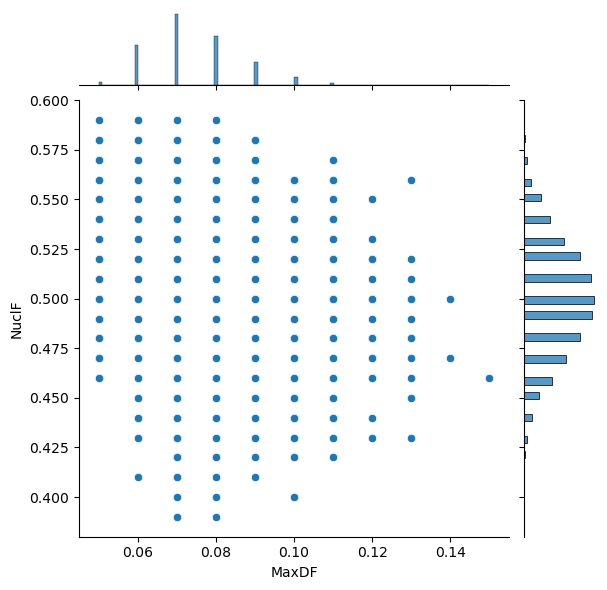

In [33]:
sns.jointplot(NR100, x='MaxDF', y='NuclF');

##### Cross redirection

In [34]:
%%time

XR100 = run_func_not('XR', next_rnd_xr, 100, 10000)

  0%|          | 0/10000 [00:00<?, ?it/s]

CPU times: user 5min 28s, sys: 2.93 s, total: 5min 31s
Wall time: 5min 29s


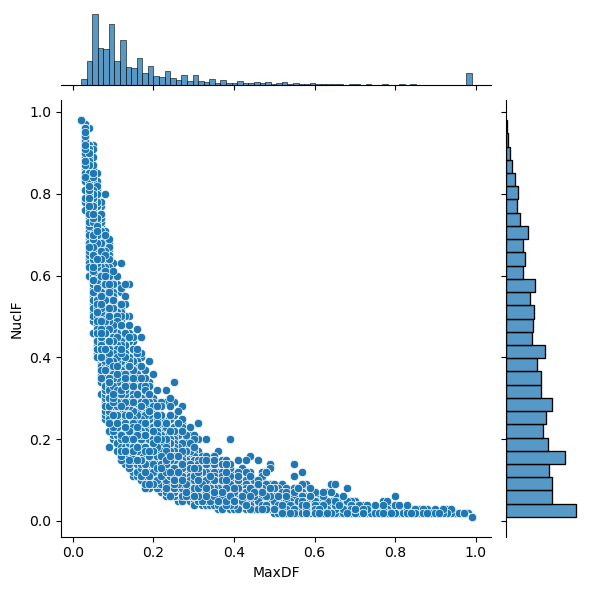

In [35]:
sns.jointplot(XR100, x='MaxDF', y='NuclF');

##### Hub redirection

In [36]:
%%time

HR100 = run_func_not('HR', next_rnd_hr, 100, 10000)

  0%|          | 0/10000 [00:00<?, ?it/s]

CPU times: user 5min 17s, sys: 2.85 s, total: 5min 20s
Wall time: 5min 19s


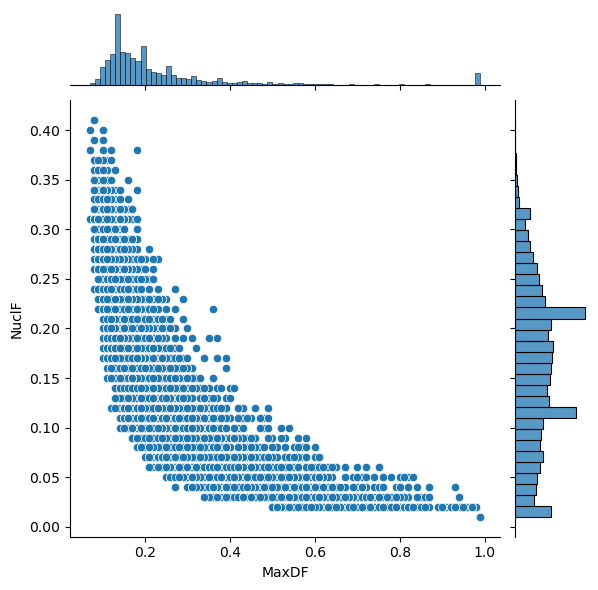

In [37]:
sns.jointplot(HR100, x='MaxDF', y='NuclF');

##### Fuzzy redirection

In [38]:
%%time

FR100 = run_func_not('FR', next_rnd_fr, 100, 10000)

  0%|          | 0/10000 [00:00<?, ?it/s]

CPU times: user 5min 14s, sys: 2.62 s, total: 5min 17s
Wall time: 5min 16s


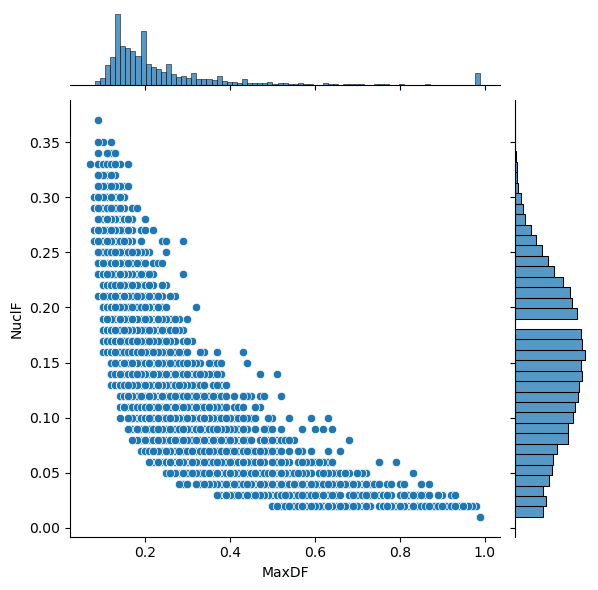

In [39]:
sns.jointplot(FR100, x='MaxDF', y='NuclF');

##### Complete redirection

In [40]:
%%time

CR100 = run_func_not('CR', next_rnd_cr, 100, 10000)

  0%|          | 0/10000 [00:00<?, ?it/s]

CPU times: user 1min 2s, sys: 262 ms, total: 1min 2s
Wall time: 1min 2s


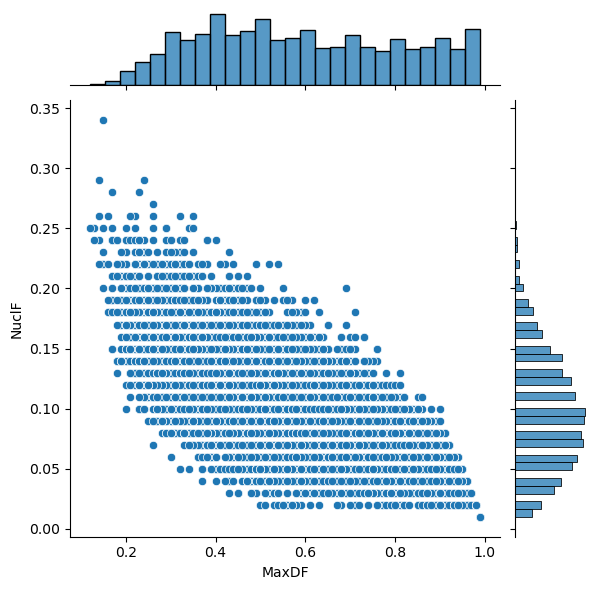

In [41]:
sns.jointplot(CR100, x='MaxDF', y='NuclF');

#### Compare

In [42]:
df100 = pd.concat([NR100, XR100, HR100, FR100, CR100], axis=0)

In [43]:
df100.groupby('Model')[['MaxDF', 'PD1', 'DPD', 'NuclF', 'PH1', 'DPH']].mean()

,MaxDF,PD1,DPD,NuclF,PH1,DPH
Model,,,,,,
CR,0.593147,0.574864,-0.000181,0.096348,0.055491,-0.000405
FR,0.251209,0.231129,-0.000199,0.144140,0.096148,-0.000475
HR,0.243884,0.222749,-0.000209,0.159495,0.101791,-0.000571
NR,0.074511,0.054326,-0.000200,0.499735,0.170432,-0.003260
XR,0.195855,0.172993,-0.000226,0.334074,0.122876,-0.002091


In [44]:
(100.)**(0.566-1)

0.13551894123510358

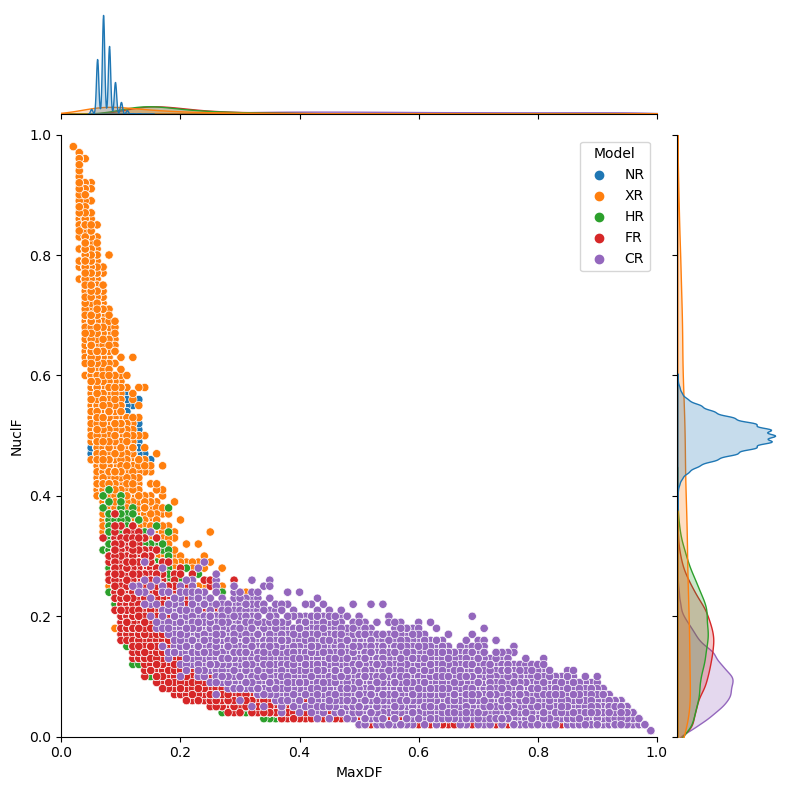

In [45]:
sns.jointplot(df100, x='MaxDF', y='NuclF', hue='Model', height=8, xlim=(0, 1), ylim=(0, 1));

In [46]:
subdf100 = pd.concat([XR100, FR100, CR100], axis=0)

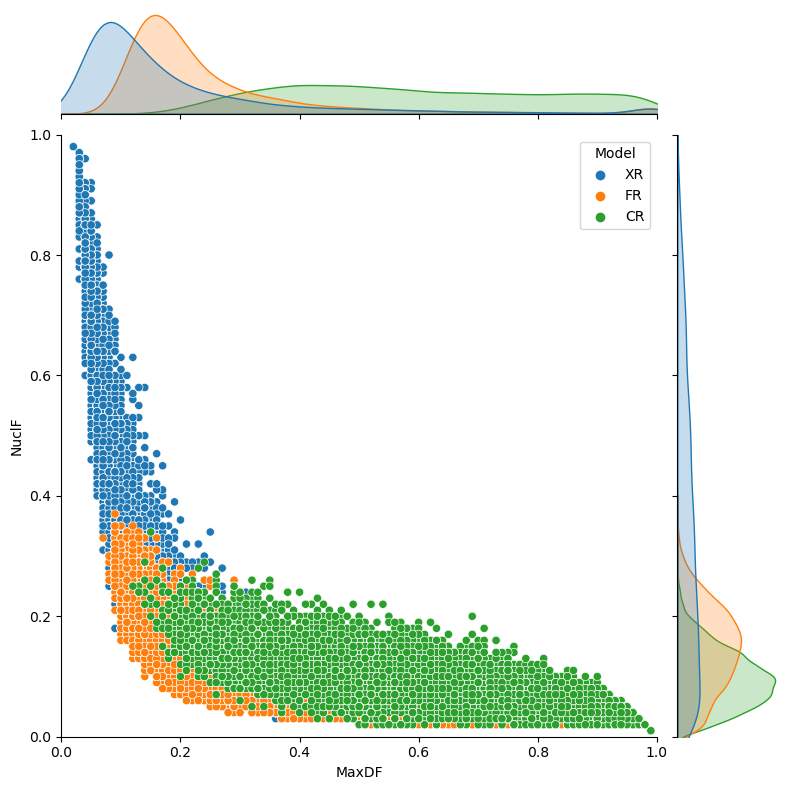

In [47]:
sns.jointplot(subdf100, x='MaxDF', y='NuclF', hue='Model', height=8, xlim=(0, 1), ylim=(0, 1));

### N=1000

##### No redirection

In [123]:
%%time

NR1000 = run_func_not('NR', next_rnd_nr, 1000, 1000)

  0%|          | 0/1000 [00:00<?, ?it/s]

CPU times: user 11min 47s, sys: 3.44 s, total: 11min 50s
Wall time: 11min 50s


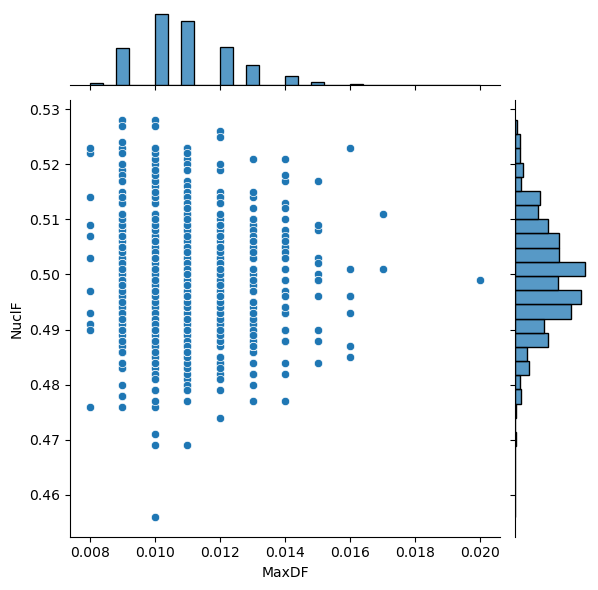

In [124]:
sns.jointplot(NR1000, x='MaxDF', y='NuclF');

##### Cross redirection

In [125]:
%%time

XR1000 = run_func_not('XR', next_rnd_xr, 1000, 1000)

  0%|          | 0/1000 [00:00<?, ?it/s]

CPU times: user 55min 49s, sys: 15.4 s, total: 56min 4s
Wall time: 56min 3s


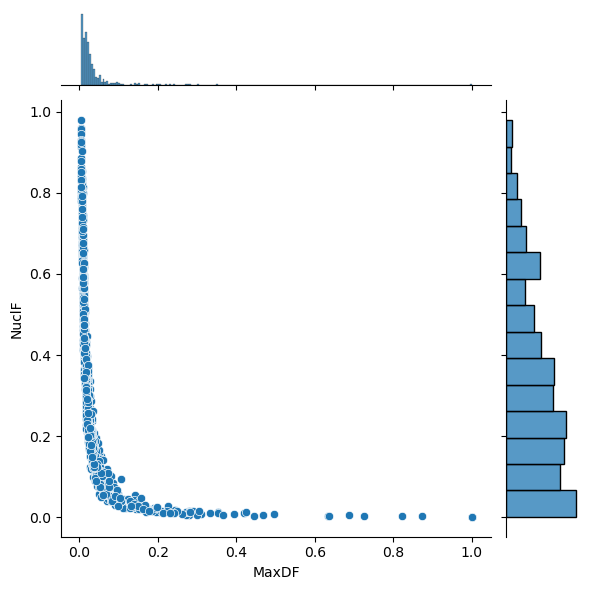

In [126]:
sns.jointplot(XR1000, x='MaxDF', y='NuclF');

##### Hub redirection

In [127]:
%%time

HR1000 = run_func_not('HR', next_rnd_hr, 1000, 1000)

  0%|          | 0/1000 [00:00<?, ?it/s]

CPU times: user 53min 31s, sys: 14.4 s, total: 53min 45s
Wall time: 53min 43s


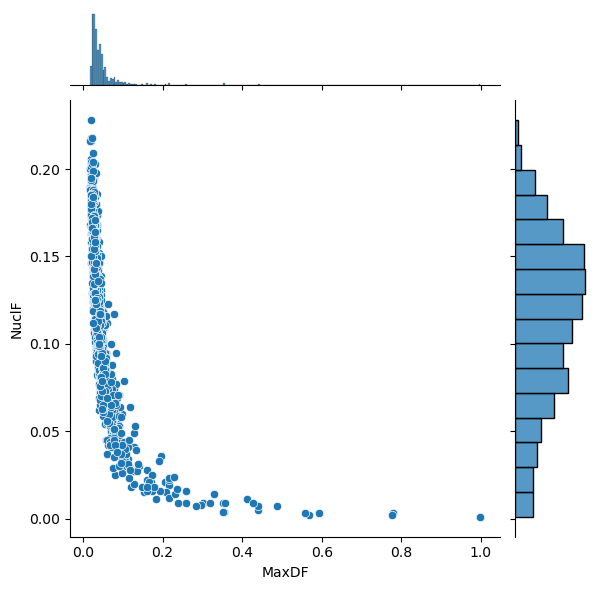

In [128]:
sns.jointplot(HR1000, x='MaxDF', y='NuclF');

##### Fuzzy redirection

In [129]:
%%time

FR1000 = run_func_not('FR', next_rnd_fr, 1000, 1000)

  0%|          | 0/1000 [00:00<?, ?it/s]

CPU times: user 53min 11s, sys: 15 s, total: 53min 26s
Wall time: 53min 23s


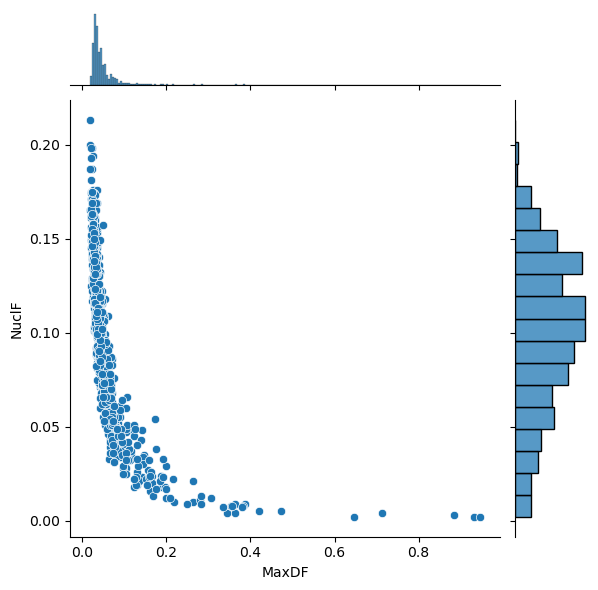

In [130]:
sns.jointplot(FR1000, x='MaxDF', y='NuclF');

##### Complete redirection

In [131]:
%%time

CR1000 = run_func_not('CR', next_rnd_cr, 1000, 1000)

  0%|          | 0/1000 [00:00<?, ?it/s]

CPU times: user 11min 27s, sys: 2.84 s, total: 11min 30s
Wall time: 11min 29s


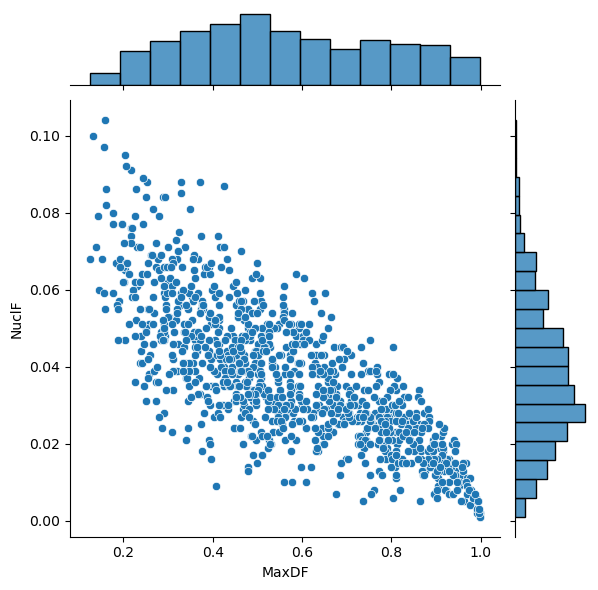

In [132]:
sns.jointplot(CR1000, x='MaxDF', y='NuclF');

#### Compare

In [133]:
df1000 = pd.concat([NR1000, XR1000, HR1000, FR1000, CR1000], axis=0)

In [156]:
df1000.groupby('Model')[['MaxDF', 'PD1', 'DPD', 'NuclF', 'PH1', 'DPH']].mean()

,MaxDF,PD1,DPD,NuclF,PH1,DPH
Model,,,,,,
CR,0.564095,0.560049,0.000522,0.037355,0.021220,-0.000016
FR,0.057984,0.052455,-0.000047,0.099036,0.074373,-0.000025
HR,0.057169,0.051212,-0.000061,0.112770,0.081663,-0.000031
NR,0.010915,0.006714,-0.000492,0.499584,0.169919,-0.000329
XR,0.048487,0.042050,-0.000281,0.323517,0.119316,-0.000204


In [29]:
(1000.)**(0.566-1)

0.0498884487460012

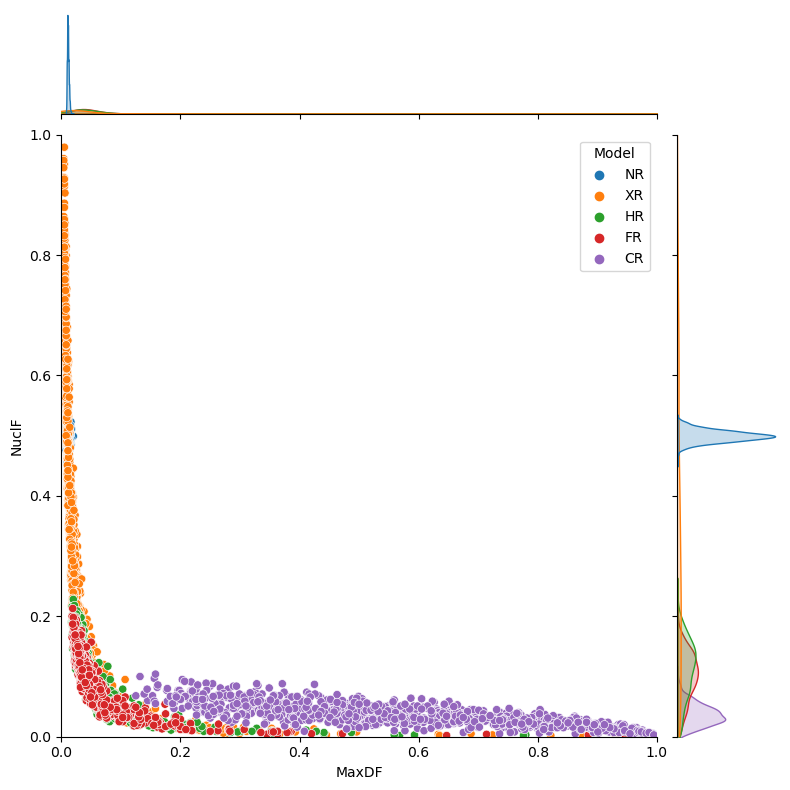

In [150]:
sns.jointplot(df1000, x='MaxDF', y='NuclF', hue='Model', height=8, xlim=(0, 1), ylim=(0, 1));

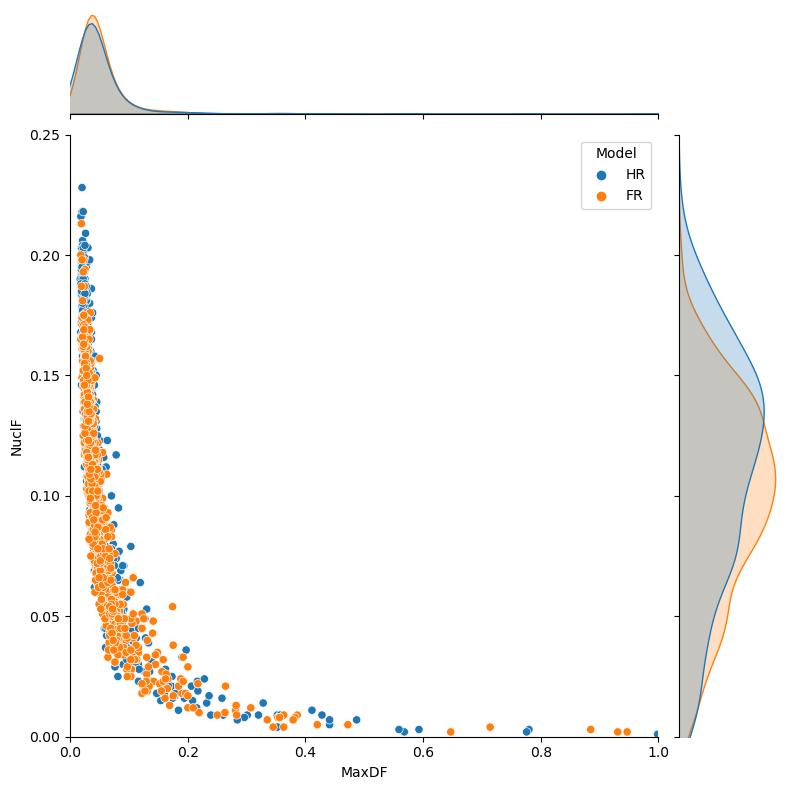

In [163]:
subdf1000 = pd.concat([HR1000, FR1000], axis=0)
sns.jointplot(subdf1000, x='MaxDF', y='NuclF', hue='Model', height=8, xlim=(0, 1), ylim=(0, 0.25));

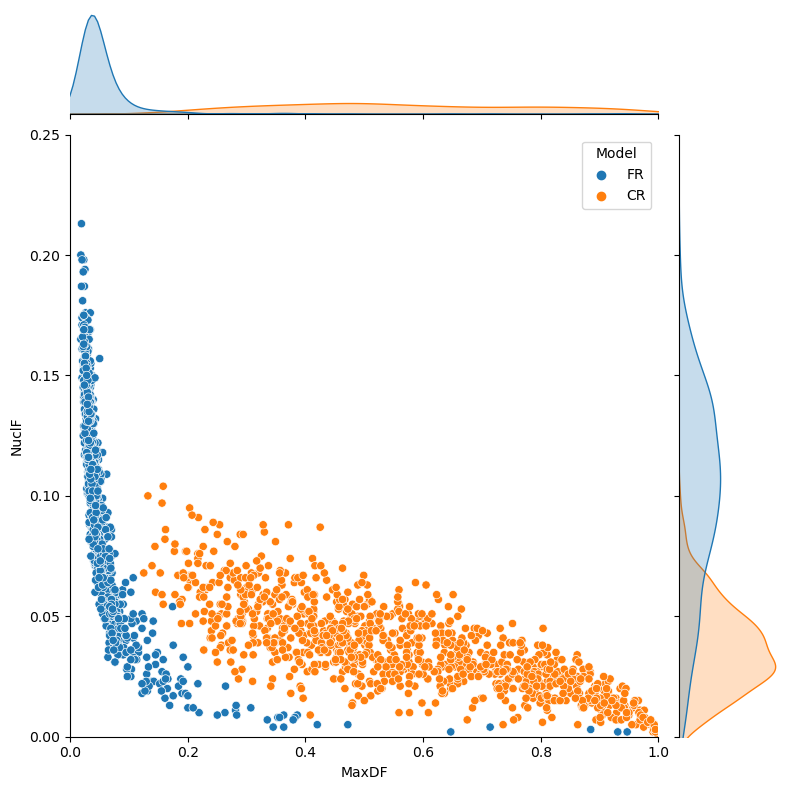

In [164]:
subdf1000 = pd.concat([FR1000, CR1000], axis=0)
sns.jointplot(subdf1000, x='MaxDF', y='NuclF', hue='Model', height=8, xlim=(0, 1), ylim=(0, 0.25));

### N=2000

##### No redirection

In [135]:
%%time

NR2000 = run_func_not('NR', next_rnd_nr, 2000, 250)

  0%|          | 0/250 [00:00<?, ?it/s]

CPU times: user 14min 2s, sys: 3.54 s, total: 14min 6s
Wall time: 14min 6s


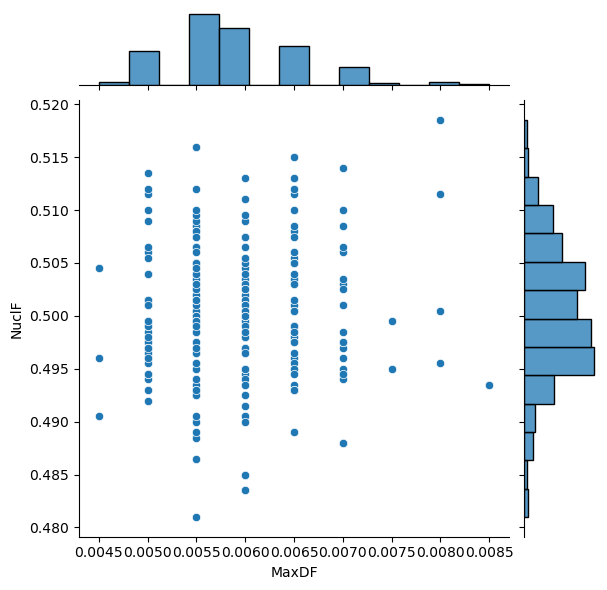

In [136]:
sns.jointplot(NR2000, x='MaxDF', y='NuclF');

##### Cross redirection

In [137]:
%%time

XR2000 = run_func_not('XR', next_rnd_xr, 1000, 250)

  0%|          | 0/250 [00:00<?, ?it/s]

CPU times: user 13min 54s, sys: 3.31 s, total: 13min 58s
Wall time: 13min 57s


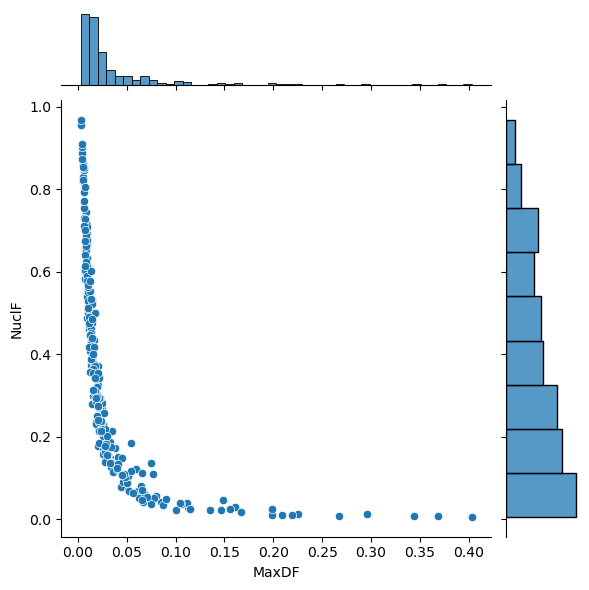

In [138]:
sns.jointplot(XR2000, x='MaxDF', y='NuclF');

##### Hub redirection

In [139]:
%%time

HR2000 = run_func_not('HR', next_rnd_hr, 2000, 250)

  0%|          | 0/250 [00:00<?, ?it/s]

CPU times: user 54min 27s, sys: 13.5 s, total: 54min 41s
Wall time: 54min 40s


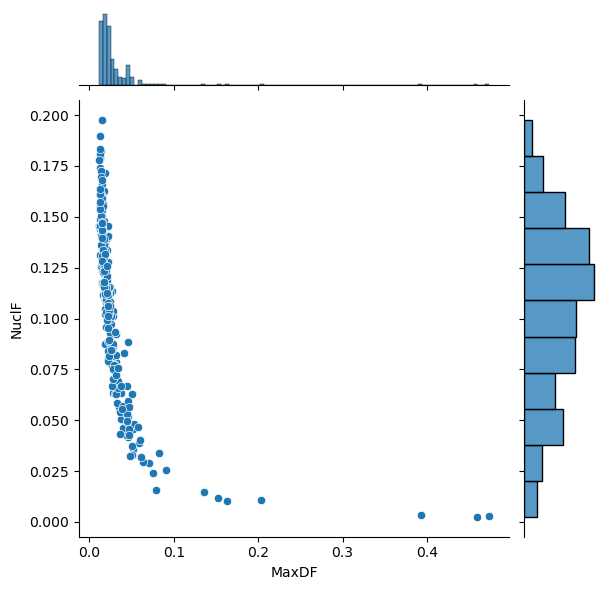

In [140]:
sns.jointplot(HR2000, x='MaxDF', y='NuclF');

##### Fuzzy redirection

In [141]:
%%time

FR2000 = run_func_not('FR', next_rnd_fr, 2000, 250)

  0%|          | 0/250 [00:00<?, ?it/s]

CPU times: user 54min 17s, sys: 13.1 s, total: 54min 30s
Wall time: 54min 29s


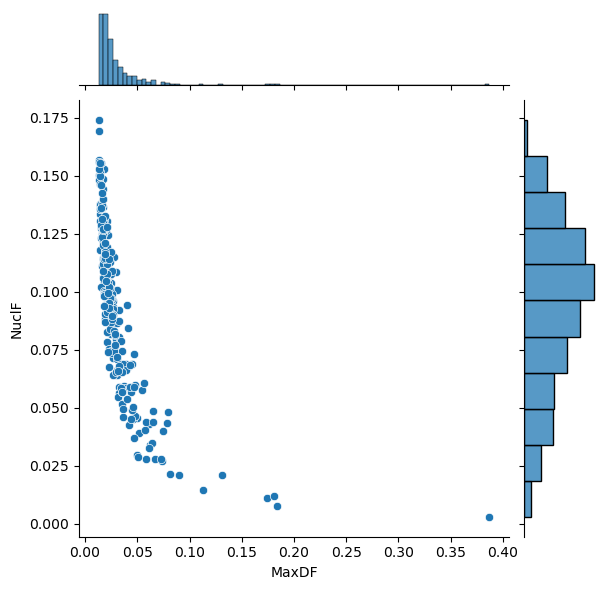

In [142]:
sns.jointplot(FR2000, x='MaxDF', y='NuclF');

##### Complete redirection

In [143]:
%%time

CR2000 = run_func_not('CR', next_rnd_cr, 2000, 250)

  0%|          | 0/250 [00:00<?, ?it/s]

CPU times: user 13min 33s, sys: 3.78 s, total: 13min 37s
Wall time: 13min 36s


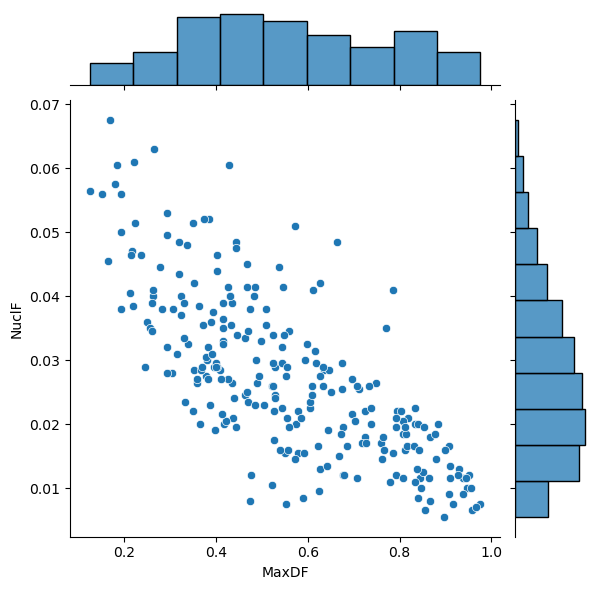

In [144]:
sns.jointplot(CR2000, x='MaxDF', y='NuclF');

#### Compare

In [145]:
df2000 = pd.concat([NR2000, XR2000, HR2000, FR2000, CR2000], axis=0)

In [157]:
df2000.groupby('Model')[['MaxDF', 'PD1', 'DPD', 'NuclF', 'PH1', 'DPH']].mean()

,MaxDF,PD1,DPD,NuclF,PH1,DPH
Model,,,,,,
CR,0.554236,0.551909,0.000262,0.027566,0.015535,-0.000006
FR,0.031738,0.027609,-0.000033,0.093672,0.071528,-0.000011
HR,0.032826,0.029097,-0.000037,0.103442,0.076817,-0.000013
NR,0.005898,0.003384,-0.000248,0.500326,0.169988,-0.000165
XR,0.038792,0.032966,-0.000317,0.350156,0.118114,-0.000232


In [30]:
(2000.)**(0.566-1)

0.03692776147008702

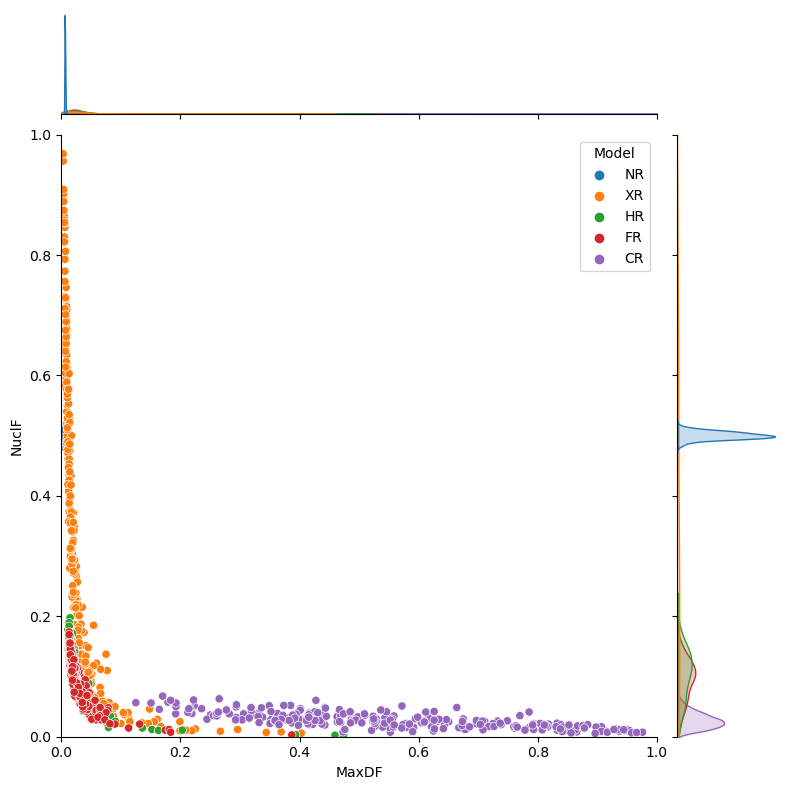

In [149]:
sns.jointplot(df2000, x='MaxDF', y='NuclF', hue='Model', height=8, xlim=(0, 1), ylim=(0, 1));

### N=10000

##### Complete redirection

In [48]:
%%time

CR10000 = run_func_not('CR', next_rnd_cr, 10000, 200)

  0%|          | 0/200 [00:00<?, ?it/s]

CPU times: user 4h 50min 23s, sys: 2min 6s, total: 4h 52min 29s
Wall time: 4h 52min 32s


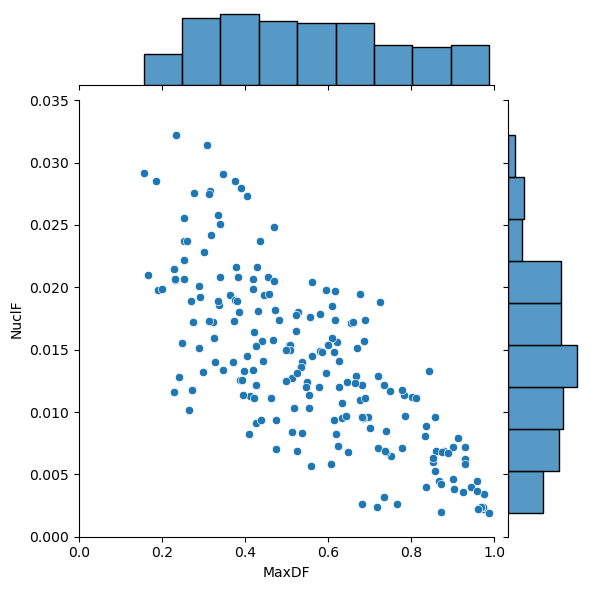

In [58]:
sns.jointplot(CR10000, x='MaxDF', y='NuclF', xlim=(0, 1), ylim=(0, 0.035));

In [59]:
CR10000[['MaxDF', 'PD1', 'DPD', 'NuclF', 'PH1', 'DPH']].describe()

,MaxDF,PD1,DPD,NuclF,PH1,DPH
count,200.000000,200.000000,2.000000e+02,200.000000,200.000000,2.000000e+02
mean,0.553375,0.552765,-6.099973e-08,0.013919,0.007905,-6.013803e-07
std,0.217137,0.217178,2.087085e-08,0.006797,0.003828,2.996266e-07
min,0.155300,0.154638,-1.241947e-07,0.001900,0.001113,-1.496667e-06
25%,0.381825,0.381104,-7.448860e-08,0.008850,0.005098,-8.064745e-07
50%,0.535500,0.535086,-5.913317e-08,0.013300,0.007674,-5.731501e-07
75%,0.705725,0.705375,-4.798063e-08,0.018825,0.010451,-3.839074e-07
max,0.988400,0.988219,-1.549845e-08,0.032200,0.017986,-6.920576e-08
